In [1]:
from matplotlib import pyplot as plt
import numpy as np
import classifier_utils
from classifier_utils import cnn_model, preprocess_img, get_class
%matplotlib inline
import glob
import os
from skimage import io
from skimage import transform
import keras
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.models import Sequential, Model
import vgg16


Using TensorFlow backend.


## Loading CIFAR10

In [2]:
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [ ]:
print (y_train[1]) 

### Array details (dimension, type):

In [ ]:
print (x_train.shape)

In [ ]:
type(x_train)

In [ ]:
#x_train.astype(np.uint8)

In [3]:
x_train = x_train.astype('float32')

In [4]:
print (x_train)

[[[[  59.   62.   63.]
   [  43.   46.   45.]
   [  50.   48.   43.]
   ..., 
   [ 158.  132.  108.]
   [ 152.  125.  102.]
   [ 148.  124.  103.]]

  [[  16.   20.   20.]
   [   0.    0.    0.]
   [  18.    8.    0.]
   ..., 
   [ 123.   88.   55.]
   [ 119.   83.   50.]
   [ 122.   87.   57.]]

  [[  25.   24.   21.]
   [  16.    7.    0.]
   [  49.   27.    8.]
   ..., 
   [ 118.   84.   50.]
   [ 120.   84.   50.]
   [ 109.   73.   42.]]

  ..., 
  [[ 208.  170.   96.]
   [ 201.  153.   34.]
   [ 198.  161.   26.]
   ..., 
   [ 160.  133.   70.]
   [  56.   31.    7.]
   [  53.   34.   20.]]

  [[ 180.  139.   96.]
   [ 173.  123.   42.]
   [ 186.  144.   30.]
   ..., 
   [ 184.  148.   94.]
   [  97.   62.   34.]
   [  83.   53.   34.]]

  [[ 177.  144.  116.]
   [ 168.  129.   94.]
   [ 179.  142.   87.]
   ..., 
   [ 216.  184.  140.]
   [ 151.  118.   84.]
   [ 123.   92.   72.]]]


 [[[ 154.  177.  187.]
   [ 126.  137.  136.]
   [ 105.  104.   95.]
   ..., 
   [  91.   95.   

In [5]:
type(x_train)

numpy.ndarray

### Switch RGB to BGR order

In [6]:
x_train = x_train[:, :, :, ::-1]  

# Subtract ImageNet mean pixel 
x_train[:, :, :, 0] -= 103
x_train[:, :, :, 1] -= 116
x_train[:, :, :, 2] -= 123

In [7]:
print (x_train)

[[[[ -40.  -54.  -64.]
   [ -58.  -70.  -80.]
   [ -60.  -68.  -73.]
   ..., 
   [   5.   16.   35.]
   [  -1.    9.   29.]
   [   0.    8.   25.]]

  [[ -83.  -96. -107.]
   [-103. -116. -123.]
   [-103. -108. -105.]
   ..., 
   [ -48.  -28.    0.]
   [ -53.  -33.   -4.]
   [ -46.  -29.   -1.]]

  [[ -82.  -92.  -98.]
   [-103. -109. -107.]
   [ -95.  -89.  -74.]
   ..., 
   [ -53.  -32.   -5.]
   [ -53.  -32.   -3.]
   [ -61.  -43.  -14.]]

  ..., 
  [[  -7.   54.   85.]
   [ -69.   37.   78.]
   [ -77.   45.   75.]
   ..., 
   [ -33.   17.   37.]
   [ -96.  -85.  -67.]
   [ -83.  -82.  -70.]]

  [[  -7.   23.   57.]
   [ -61.    7.   50.]
   [ -73.   28.   63.]
   ..., 
   [  -9.   32.   61.]
   [ -69.  -54.  -26.]
   [ -69.  -63.  -40.]]

  [[  13.   28.   54.]
   [  -9.   13.   45.]
   [ -16.   26.   56.]
   ..., 
   [  37.   68.   93.]
   [ -19.    2.   28.]
   [ -31.  -24.    0.]]]


 [[[  84.   61.   31.]
   [  33.   21.    3.]
   [  -8.  -12.  -18.]
   ..., 
   [ -32.  -21.  -

### Image resizing. Vgg16 takes minimum size of 48x48

In [8]:
x_train_vgg = np.zeros((50000,224,224,3))

for i in range(50000):
    x_train_vgg[i] = transform.resize(x_train[i], (224, 224), order=0, preserve_range=True)

/usr/local/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [9]:
print (x_train_vgg)

[[[[ -40.  -54.  -64.]
   [ -40.  -54.  -64.]
   [ -40.  -54.  -64.]
   ..., 
   [   0.    8.   25.]
   [   0.    8.   25.]
   [   0.    8.   25.]]

  [[ -40.  -54.  -64.]
   [ -40.  -54.  -64.]
   [ -40.  -54.  -64.]
   ..., 
   [   0.    8.   25.]
   [   0.    8.   25.]
   [   0.    8.   25.]]

  [[ -40.  -54.  -64.]
   [ -40.  -54.  -64.]
   [ -40.  -54.  -64.]
   ..., 
   [   0.    8.   25.]
   [   0.    8.   25.]
   [   0.    8.   25.]]

  ..., 
  [[  13.   28.   54.]
   [  13.   28.   54.]
   [  13.   28.   54.]
   ..., 
   [ -31.  -24.    0.]
   [ -31.  -24.    0.]
   [ -31.  -24.    0.]]

  [[  13.   28.   54.]
   [  13.   28.   54.]
   [  13.   28.   54.]
   ..., 
   [ -31.  -24.    0.]
   [ -31.  -24.    0.]
   [ -31.  -24.    0.]]

  [[  13.   28.   54.]
   [  13.   28.   54.]
   [  13.   28.   54.]
   ..., 
   [ -31.  -24.    0.]
   [ -31.  -24.    0.]
   [ -31.  -24.    0.]]]


 [[[  84.   61.   31.]
   [  84.   61.   31.]
   [  84.   61.   31.]
   ..., 
   [ -33.  -35.  -

In [11]:
#1st model
#IMG_SIZE = 32
#2nd model
IMG_SIZE = 224 
NUM_CLASSES = 10

### Reducing amount of pictures

In [13]:
#2nd model
x_train_vgg = x_train_vgg[0:50000] #bigger value
y_train_vgg = y_train[0:50000]

In [14]:
print (x_train_vgg.shape)

(50000, 224, 224, 3)


### Why already calculated values? By default on .resize

In [ ]:
print (x_train_vgg)

#### Examples from training set (224x224 and 32x32)

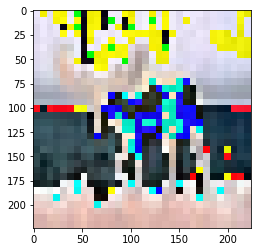

In [15]:
single_image = x_train_vgg[28:29]
plt.imshow(single_image[0])         

In [ ]:
single_image = x_train[58:59]
plt.imshow(single_image[0])         

### Zdjecie warstwy: include_top=False

In [ ]:
#first_model = cnn_model(IMG_SIZE,NUM_CLASSES)

In [16]:
second_model = keras.applications.vgg16.VGG16(include_top=False, weights='imagenet', input_tensor=None, input_shape=(224,224,3), pooling=max)

### Choose model (remember to set NUM_CLASSES)

In [17]:
#model = first_model
model = second_model

In [18]:
model.layers

In [ ]:
model.layers[2]

### Setting all layers to trainable

In [19]:
for layer in model.layers: layer.trainable=True

In [ ]:
model.summary()

### Alternative way to add last layer and activation 

In [20]:
#model.add(Dense(NUM_CLASSES, activation='softmax')) .add doesn't work for VGG16

last = model.output

x = Flatten()(last)
preds = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(model.input, preds)

In [ ]:
model.layers

In [21]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

### Set optimizer for tweaks (leraning rate lr=0.001 to lr=0.0001) !Unquote Adam!

In [22]:
Adam=keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

In [23]:
model.compile(optimizer=Adam,loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [25]:
#1st model
#model.fit(x_train, y_train, batch_size=128, epochs=10)
#2nd model
#model.fit(x_train_vgg, y_train_vgg, batch_size=128, epochs=2)
model.fit(x_train_vgg, y_train_vgg, batch_size=128, epochs=1)

Epoch 1/1


ResourceExhaustedError: OOM when allocating tensor with shape[128,64,112,112]
	 [[Node: gradients/block1_pool/MaxPool_grad/MaxPoolGrad = MaxPoolGrad[T=DT_FLOAT, _class=["loc:@block1_pool/MaxPool"], data_format="NHWC", ksize=[1, 2, 2, 1], padding="VALID", strides=[1, 2, 2, 1], _device="/job:localhost/replica:0/task:0/gpu:0"](block1_conv2/Relu, block1_pool/MaxPool, gradients/block2_conv1/convolution_grad/Conv2DBackpropInput)]]

Caused by op 'gradients/block1_pool/MaxPool_grad/MaxPoolGrad', defined at:
  File "/usr/local/lib/python3.5/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/local/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/usr/local/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/usr/local/lib/python3.5/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/usr/local/lib/python3.5/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python3.5/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2698, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2808, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/local/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-24-2f3b5eb9fd40>", line 5, in <module>
    model.fit(x_train_vgg, y_train, batch_size=128, epochs=1)
  File "/usr/local/lib/python3.5/site-packages/keras/engine/training.py", line 1413, in fit
    self._make_train_function()
  File "/usr/local/lib/python3.5/site-packages/keras/engine/training.py", line 937, in _make_train_function
    self.total_loss)
  File "/usr/local/lib/python3.5/site-packages/keras/optimizers.py", line 404, in get_updates
    grads = self.get_gradients(loss, params)
  File "/usr/local/lib/python3.5/site-packages/keras/optimizers.py", line 71, in get_gradients
    grads = K.gradients(loss, params)
  File "/usr/local/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py", line 2305, in gradients
    return tf.gradients(loss, variables, colocate_gradients_with_ops=True)
  File "/usr/local/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py", line 560, in gradients
    grad_scope, op, func_call, lambda: grad_fn(op, *out_grads))
  File "/usr/local/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py", line 368, in _MaybeCompile
    return grad_fn()  # Exit early
  File "/usr/local/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py", line 560, in <lambda>
    grad_scope, op, func_call, lambda: grad_fn(op, *out_grads))
  File "/usr/local/lib/python3.5/site-packages/tensorflow/python/ops/nn_grad.py", line 438, in _MaxPoolGrad
    data_format=op.get_attr("data_format"))
  File "/usr/local/lib/python3.5/site-packages/tensorflow/python/ops/gen_nn_ops.py", line 1737, in _max_pool_grad
    data_format=data_format, name=name)
  File "/usr/local/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 768, in apply_op
    op_def=op_def)
  File "/usr/local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2336, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/usr/local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1228, in __init__
    self._traceback = _extract_stack()

...which was originally created as op 'block1_pool/MaxPool', defined at:
  File "/usr/local/lib/python3.5/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
[elided 16 identical lines from previous traceback]
  File "/usr/local/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2698, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2802, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/local/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-16-45489d500130>", line 1, in <module>
    second_model = keras.applications.vgg16.VGG16(include_top=False, weights='imagenet', input_tensor=None, input_shape=(224,224,3), pooling=max)
  File "/usr/local/lib/python3.5/site-packages/keras/applications/vgg16.py", line 113, in VGG16
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)
  File "/usr/local/lib/python3.5/site-packages/keras/engine/topology.py", line 596, in __call__
    output = self.call(inputs, **kwargs)
  File "/usr/local/lib/python3.5/site-packages/keras/layers/pooling.py", line 154, in call
    data_format=self.data_format)
  File "/usr/local/lib/python3.5/site-packages/keras/layers/pooling.py", line 217, in _pooling_function
    pool_mode='max')
  File "/usr/local/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py", line 3378, in pool2d
    x = tf.nn.max_pool(x, pool_size, strides, padding=padding)
  File "/usr/local/lib/python3.5/site-packages/tensorflow/python/ops/nn_ops.py", line 1821, in max_pool
    name=name)
  File "/usr/local/lib/python3.5/site-packages/tensorflow/python/ops/gen_nn_ops.py", line 1638, in _max_pool
    data_format=data_format, name=name)
  File "/usr/local/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 768, in apply_op
    op_def=op_def)
  File "/usr/local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2336, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/usr/local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1228, in __init__
    self._traceback = _extract_stack()

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[128,64,112,112]
	 [[Node: gradients/block1_pool/MaxPool_grad/MaxPoolGrad = MaxPoolGrad[T=DT_FLOAT, _class=["loc:@block1_pool/MaxPool"], data_format="NHWC", ksize=[1, 2, 2, 1], padding="VALID", strides=[1, 2, 2, 1], _device="/job:localhost/replica:0/task:0/gpu:0"](block1_conv2/Relu, block1_pool/MaxPool, gradients/block2_conv1/convolution_grad/Conv2DBackpropInput)]]


### Set test size to 64x64

In [ ]:
x_test_vgg = np.zeros((10000,224,224,3))

for i in range(10000):
    x_test_vgg[i] = transform.resize(x_test[i], (224, 224), order=0)

In [ ]:
print (x_test_vgg.shape)

In [ ]:
model.evaluate(x_test_vgg, y_test)